In [6]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
from friend_groups import *
from modeling import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 36)

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

from itertools import product
from collections import defaultdict

SETTING UP DATA FOR PREDICTION

In [7]:
mongoClientName = "mongodb://XXX" # replace XXX with the location of your mongo client
# here I used one of my Amazon EC2 instances and its associated storage as a central location for MongoDB
client = MongoClient(mongoClientName)

In [8]:
added_later = {'huckFinn', 'eatPrayLove', 'valis', 'mistborn', 'catsCradle',
              'secret', 'dorianGray', 'rothfussName'}

allComms = collectAllComms(client, db_exclude={}, removeOutliers=False)

Checking database 'goodreads_explore_from_book_heLa'
Comms collection malformed or empty: expected 1 record, found 0 records

Checking database 'goodreads_explore_from_book_rebelOfTheSands'
Comms collection malformed or empty: expected 1 record, found 0 records

Checking database 'goodreads_explore_from_book_aCourtOfMistAndFury'
Comms collection malformed or empty: expected 1 record, found 0 records

Checking database 'goodreads_explore_from_book_evicted'
Comms collection malformed or empty: expected 1 record, found 0 records

Checking database 'goodreads_explore_from_book_beautifulDisaster'
Comms collection malformed or empty: expected 1 record, found 0 records

Checking database 'goodreads_explore_from_book_childhoodsEnd'
Comms collection malformed or empty: expected 1 record, found 0 records

Checking database 'goodreads_explore_from_book_theMirrorKing'
Comms collection malformed or empty: expected 1 record, found 0 records

Checking database 'goodreads_explore_from_book_outlander'


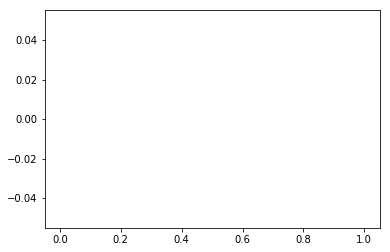

In [4]:
plt.hist([len(c) for c in allComms]);

In [ ]:
dbFull = client['goodreads_full']

ratingsFull = dbFull['ratings']
friendsFull = dbFull['friends']
booksFull = dbFull['books']

#updateCommsOfRaters2(booksFull, allComms)
#updateCommsOfRaters(ratingsFull, booksFull, allComms)
booksToRaterComms = getCommsOfRaters(ratingsFull, allComms)

In [ ]:
glRatings = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20, False)
#outlierDict, glRatingsNoOutliers = removeGlOutliers(glRatings)

In [ ]:
#glRatings = glRatingsNoOutliers

In [ ]:
trainSplitRmses = []
trainSplitRmsesFake = []

In [ ]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID",
                                                    max_num_users=1000,
                                                    item_test_proportion=0.2)
'''

glRatingsTrain, glRatingsTest = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20,\
                                                     True, datetime.strptime('Apr 17, 2013', grDateFormat))

glRatingsTrain = glRatingsTrain[glRatingsTrain['comm'].apply(lambda x: outlierDict[x])]
glRatingsTest = glRatingsTest[glRatingsTest['comm'].apply(lambda x: outlierDict[x])]
'''

In [ ]:
# EDA comparing movielens to GR
# loading data

header = ['user_id', 'item_id', 'rating', 'timestamp']
df_ml = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
df_ml = df_ml.rename(columns={'user_id':'userID','item_id':'bookID'})

df_gr = glRatings.to_dataframe()

In [ ]:
# EDA comparing movielens to GR

df_ml_users = df_ml.groupby(['userID'])['rating'].count()
print 'movielens: ratings per user stats\n'
print df_ml_users.describe()

print '\n\ngoodreads: ratings per user stats\n'
df_gr_users = df_gr.groupby(['userID'])['rating'].count()
print df_gr_users.describe()

df_ml_items = df_ml.groupby(['bookID'])['rating'].count()
print '\n\nmovielens: ratings per item stats\n'
print df_ml_items.describe()

print '\n\ngoodreads: ratings per item stats\n'
df_gr_items = df_gr.groupby(['bookID'])['rating'].count()
print df_gr_items.describe()

In [ ]:
histStuff= plt.hist(df_ml_users,alpha=0.25,normed=True,log=True,bins=np.linspace(0,300,30),label='ml');
plt.hist(df_gr_users,alpha=0.25,bins=histStuff[1],normed=True,log=True,color='r',label='gr');
plt.legend(title='PDF: ratings per user');

In [ ]:
histStuff= plt.hist(df_ml_items,alpha=0.25,normed=True,log=True,bins=np.linspace(0,300,30),label='ml');
plt.hist(df_gr_items,alpha=0.25,bins=histStuff[1],normed=True,log=True,color='r',label='gr');
plt.legend(title='PDF: ratings per items');

In [ ]:
plt.plot(df_ml_users,df_ml_users.rank()/len(df_ml_users.rank()),'o',label='ml');
plt.plot(df_gr_users,df_gr_users.rank()/len(df_gr_users.rank()),'o',label='gr');
plt.axis([0,300,0,1])
plt.legend(title='CDF: ratings per user');

In [ ]:
plt.plot(df_ml_items,df_ml_items.rank()/len(df_ml_items.rank()),'o',label='ml');
plt.plot(df_gr_items,df_gr_items.rank()/len(df_gr_items.rank()),'o',label='gr');
plt.axis([0,100,0,1])
plt.legend(title='CDF: ratings per item');

In [ ]:
# testing on movielens

# header = ['user_id', 'item_id', 'rating', 'timestamp']
# df_ml = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
# df_ml = df_ml.rename(columns={'user_id':'userID','item_id':'bookID'})

# glRatings = gl.SFrame(df_ml)

# glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
#                                                     user_id="userID", 
#                                                     item_id="bookID",
#                                                     max_num_users=None,
#                                                     item_test_proportion=0.1)

In [ ]:
# removing intercept and user/book means

# intercept = glRatingsTrain['rating'].mean()

# glRatingsTrain['rating'] = glRatingsTrain['rating'] - intercept

# userMeans = glRatingsTrain.groupby(['userID'],{'userMeans': gl.aggregate.AVG('rating')})
# bookMeans = glRatingsTrain.groupby(['bookID'],{'bookMeans': gl.aggregate.AVG('rating')})

# userMeansDict = defaultdict(float,{u['userID']:u['userMeans'] for u in userMeans})
# bookMeansDict = defaultdict(float,{b['bookID']:b['bookMeans'] for b in bookMeans})

# userShiftsTrain = glRatingsTrain.apply(lambda x: userMeansDict[x['userID']])
# bookShiftsTrain = glRatingsTrain.apply(lambda x: bookMeansDict[x['bookID']])

# glRatingsTrain['rating'] = glRatingsTrain['rating'] - userShiftsTrain - bookShiftsTrain

In [ ]:
# removing intercept and user/book means

# removing train means from test here is not data leakage -- it's a hack to mimic a recommender that memorizes
# the means from the training data and uses them to predict
# (to get around the fact that graphlab's recommenders can't use ALS optimization with linear/intercept terms)

# glRatingsTest['rating'] = glRatingsTest['rating'] - intercept

# userShiftsTest = glRatingsTest.apply(lambda x: userMeansDict[x['userID']])
# bookShiftsTest = glRatingsTest.apply(lambda x: bookMeansDict[x['bookID']])

# glRatingsTest['rating'] = glRatingsTest['rating'] - userShiftsTest - bookShiftsTest

In [ ]:
print glRatingsTrain.shape[0]
print glRatingsTest.shape[0]
print float(glRatingsTest.shape[0]) / (glRatingsTest.shape[0] + glRatingsTrain.shape[0])

In [ ]:
numRatingsByUser = glRatings.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByUser = pd.Series(numRatingsByUser)
numRatingsByUser.describe()
#(numRatingsByUser >= 20).mean()

In [ ]:
numRatingsByBook = glRatings.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByBook = pd.Series(numRatingsByBook)
(numRatingsByBook >= 20).mean()
numRatingsByBook.describe()

PREDICTION

TRADITIONAL RECOMMENDER

In [ ]:
# make sure we train the recommender without community information

glRatingsTrainWithComm = glRatingsTrain.copy()
glRatingsTestWithComm = glRatingsTest.copy()

if 'comm' in glRatingsTrain.column_names():
    glRatingsTrain.remove_column('comm');
if 'comm' in glRatingsTest.column_names():
    glRatingsTest.remove_column('comm');

In [ ]:
degreesOfFreedomStats(glRatingsTrain)

In [ ]:

#TRANSFORMING TO UNIFORM DISTRIBUTION
rating_cats = range(1,6)
rating_counts = np.array([sum(np.array(glRatingsTrain['rating']) == rating) for rating in rating_cats])
transformed_ratings = 1 + np.cumsum(4*rating_counts/float(rating_counts.sum()))
transformed_rating_dict = dict(zip(rating_cats,transformed_ratings))
transformed_rating_dict_inv = {v:k for (k,v) in transformed_rating_dict.items()}

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(glRatingsTest['rating'],normed=True,alpha=1,bins=[0.5,2.5,4.5,6.5]);
plt.subplot(122)
plt.hist(glRatingsTest['rating'].apply(lambda x: transformed_rating_dict[x]),normed=True,alpha=0.5,color='r',\
        bins=[0.5,2.5,4.5,6.5]);

In [ ]:
#the two lines below scale to uniform dist
glRatingsTrain['rating'] = glRatingsTrain['rating'].apply(lambda x: transformed_rating_dict[x])
glRatingsTest['rating'] = glRatingsTest['rating'].apply(lambda x: transformed_rating_dict[x])

In [ ]:
file_path_train='gl_gr_train'
file_path_test='gl_gr_test'
file_path_all='gl_gr_all'

glRatingsTrain['userID','bookID','rating'].export_csv(file_path_train,header=True,delimiter='\t')
glRatingsTest['userID','bookID','rating'].export_csv(file_path_test,header=True,delimiter='\t')
glRatings['userID','bookID','rating'].export_csv(file_path_all,header=True,delimiter='\t')
#glRatingsTrain = gl.SFrame.read_csv(file_path_train,header=True,delimiter='\t')
#glRatingsTest = gl.SFrame.read_csv(file_path_test,header=True,delimiter='\t')

In [ ]:
from surprise import SVD, KNNBaseline
from surprise import Dataset, Reader
from surprise import evaluate, GridSearch, print_perf

In [ ]:
reader = Reader(line_format='user item rating', sep='\t', skip_lines=1)
surpriseTrain = Dataset.load_from_file(file_path_train, reader=reader).build_full_trainset()
surpriseTest = Dataset.load_from_file(file_path_test, reader=reader).build_full_trainset()

train_folds = Dataset.load_from_file(file_path_all, reader=reader)
train_folds.split(5)

In [ ]:
kNNBaseline_GridSearch = GridSearch(KNNBaseline, {'k':range(50,130,10)}, measures=['rmse','fcp'])
kNNBaseline_GridSearch.evaluate(train_folds)

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot([kNNBaseline_GridSearch.cv_results['params'][i]['k'] for i in range(8)],
        [kNNBaseline_GridSearch.cv_results['scores'][i]['RMSE'] for i in range(8)])
plt.subplot(122)
plt.plot([kNNBaseline_GridSearch.cv_results['params'][i]['k'] for i in range(8)],
        [kNNBaseline_GridSearch.cv_results['scores'][i]['FCP'] for i in range(8)])

In [ ]:
gr_KNNBaseline = KNNBaseline(k=kNNBaseline_GridSearch.best_params['rmse']['k'])

gr_KNNBaseline.train(surpriseTrain)


preds=[gr_KNNBaseline.predict(str(row['userID']),str(row['bookID']),row['rating']) for row in glRatingsTest]
preds_est = np.array([preds[i].est for i in range(len(preds))])
preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

errs = preds_true - preds_est
rmse = np.sqrt((errs**2).mean())
rmse

In [ ]:
grid = {'n_factors': [160], 'reg_all': [2e-1,1e-1],
                                  'reg_bu': [1e-10], 'reg_bi': [1e-10],
                                  'n_epochs':[60,120,400], 'lr_all': [1e-2,5e-3,1e-3]}
dd = [[(k, v) for v in grid[k]] for k in grid]
grid_list = [{param[0]: param[1] for param in t} for t in product(*dd) ]

grid_rmses = {}
for i, params in enumerate(grid_list):
    print 'Parameters combination %d of %d' % (i, len(grid_list))
    print params
    gr_SVD = SVD(**params)
    gr_SVD.train(surpriseTrain)

    preds=[gr_SVD.predict(str(row['userID']),str(row['bookID']),row['rating']) for row in glRatingsTest]
    preds_est = np.array([preds[i].est for i in range(len(preds))])
    preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

    errs = preds_true - preds_est
    rmse = np.sqrt((errs**2).mean())
    print rmse
    print ''
    params_tup = tuple((k, v) for k, v in params.iteritems())
    grid_rmses[params_tup] = rmse

In [ ]:
rmses_list = grid_rmses.items()
sort_inds = np.argsort([v for k, v in rmses_list])
# for i in range(len(sort_inds)):
#     print {k:v for k, v in rmses_list[sort_inds[i]][0]}
#     print rmses_list[sort_inds[i]][1]
#     print ''

In [ ]:
gl_grid = {rmses_list[sort_inds[0]][0][i][0]: \
           [rmses_list[ind][0][i][1] for ind in sort_inds] for i in range(len(grid))}
gl_grid['rmse'] = [rmses_list[ind][1] for ind in sort_inds]
gl_output = gl.SFrame(gl_grid)
gl_output.print_rows(20)

In [ ]:
epochs = [5, 20, 100, 200, 400, 800, 1600]
rmses = []

for ep in epochs:
    gr_SVD = SVD(lr_all=0.001, n_epochs=ep, n_factors=160, reg_all=0.1, reg_bu=1e-10, reg_bi=1e-10)
    
    gr_SVD.train(surpriseTrain)

    preds=[gr_SVD.predict(str(row['userID']),str(row['bookID']),row['rating']) for row in glRatingsTest]
    preds_est = np.array([preds[i].est for i in range(len(preds))])
    preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

    errs = preds_true - preds_est
    rmse = np.sqrt((errs**2).mean())
    rmses.append(rmse)

In [ ]:
plt.plot(epochs,rmses)

In [ ]:
rmses

In [ ]:
best_params = {k:v for k,v in rmses_list[sort_inds[0]][0]}
gr_SVD = SVD(**best_params)

gr_SVD.train(surpriseTrain)

preds=[gr_SVD.predict(str(row['userID']),str(row['bookID']),row['rating']) for row in glRatingsTest]
preds_est = np.array([preds[i].est for i in range(len(preds))])
preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

errs = preds_true - preds_est
rmse = np.sqrt((errs**2).mean())
rmse

In [ ]:
to_outer_iid = {surpriseTrain.to_inner_iid(bID): bID for bID in glRatingsTrain['bookID']}


factor_norms_sq = np.array([gr_SVD.qi[:,i].dot(gr_SVD.qi[:,i]) for i in range(80)])
factor_argsort = np.argsort(factor_norms_sq)
for i in range(1):
    factor = gr_SVD.qi[:,factor_argsort[i]]
    loadings_argsort = np.argsort(factor)
    for j in range(5):
        print bookTitle(to_outer_iid[loadings_argsort[j]])
        print factor[loadings_argsort[j]]
    print '\n'
    for j in range(5):
        print bookTitle(to_outer_iid[loadings_argsort[::-1][j]])
        print factor[loadings_argsort[::-1][j]]

In [ ]:
loadings_argsort

SOCIAL MODELS

In [ ]:
glCommMeansTrain, glCommBookMeansTrain, commMeansTrain, commBookMeansTrain = \
makeSocialModelInputs(glRatingsTrainWithComm)

In [ ]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByUserDict = defaultdict(int, {r['userID']: r['numRatings'] for r in numRatingsByUser})

numRatingsByBook = glRatingsTrain.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByBookDict = defaultdict(int, {r['bookID']: r['numRatings'] for r in numRatingsByBook})

numTrainRatings_Test = np.array(glRatingsTestWithComm['bookID'].apply(lambda x: numRatingsByBookDict[x]))

In [ ]:
adjXmax = 100.
adjX = numTrainRatings_Test.copy()
adjX[adjX>adjXmax] = adjXmax
adjWeights = np.tan(2.7*(adjX-(adjXmax/2))/adjXmax)
adjWeights = adjWeights / (max(adjWeights)-min(adjWeights))
adjWeights = adjWeights - min(adjWeights)

#plt.plot(numTrainRatings_Test, adjWeights, 'o')
plt.hist(adjWeights)
np.median(adjWeights)

In [ ]:
'''
adjWeights=(100. - np.linspace(0,100,100))/100.
adjWeights[adjWeights<0]=0
adjWeights = adjWeights**(0.5)
plt.plot(np.linspace(0,100,100), adjWeights)
'''
adjX = np.linspace(0,150,100)
adjWeights = 0.5*(adjX<30) + 0.5*(adjX < 150)
adjWeights2 = np.tan(-2.7*(adjX-75)/150)
adjWeights2 = adjWeights2 / (2*max(adjWeights2))
adjWeights2 = adjWeights2 - min(adjWeights2)
plt.plot(adjX, adjWeights)
plt.plot(adjX, adjWeights2)


In [ ]:
rec_engine = surprisePredWrapper(gr_SVD)

meanWeights = np.linspace(0,0.5,20)

#SIMPLE PREDICTION FROM COMM MEANS

rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, weight)[1])



#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, False, weight)[1])

# trainSplitRmses.append(rmsesSimpleNoBookMeans)

#SANITY CHECK

# rmsesFake = []

# for weight in meanWeights:
#     rmsesFake.append(\
#                 mixedPred(glRatingsTestFakeComms, \
#                           fakeCommMeansTrain, fakeCommBookMeansTrain, fakeCommBookMeansTrain, rec_engine, rec_engine, \
#                           numTrainRatings_Test,\
#                           False, False, False, weight)[1])

# #FACTORIZING COMM MEANS
# rmsesFac = []
# for weight in meanWeights:
#     rmsesFac.append(\
#                 mixedPred(glRatingsTestWithComm, \
#                           commMeansTrain, commBookMeansTrain, rec_engine_8, rec_engine_8 \
#                           commMeans_rec_engine_baseline, True, False, True, weight)[1])

In [ ]:
plt.plot(meanWeights, rmsesSimple)
plt.plot(meanWeights, rmsesSimpleNoBookMeans)

optimalWeight = meanWeights[np.argmin(rmsesSimple)]

In [ ]:
optimalPreds = pd.Series(mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, optimalWeight)[0])

In [ ]:
plt.hist(glRatingsTest['rating'],normed=True,bins=[0.5,1.5,2.5,3.5,4.5,5.5],alpha=0.5);
plt.hist(optimalPreds,normed=True,bins=[0.5,1.5,2.5,3.5,4.5,5.5],alpha=0.5,color='r');

In [ ]:
preds_by_rating = []
rating_cats = range(1,6)

for rating in rating_cats:
    preds_by_rating.append(list(optimalPreds[pd.Series(glRatingsTestWithComm['rating'] == rating).astype(bool)]))

plt.violinplot(preds_by_rating, positions=rating_cats,showmeans=True);
plt.plot([1,5],[1,5])
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');

In [ ]:
preds_by_rating = []
rating_cats = range(1,6)

interval_eps = 0.001;
transformed_rating_intervals = [(transformed_rating_dict[r] - 0.001, transformed_rating_dict[r] + 0.001)\
                                for r in rating_cats]

for rating in rating_cats:
    preds_by_rating.append(list(optimalPreds[pd.Series(glRatingsTestWithComm['rating'] == rating).astype(bool)]))

plt.violinplot(preds_by_rating, positions=[transformed_rating_dict[r] for r in rating_cats],showmeans=True);
plt.plot([min(transformed_rating_dict),max(transformed_rating_dict)],[min(transformed_rating_dict),max(transformed_rating_dict)])
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');

In [ ]:
plt.figure(figsize=(14,8))

blueLabel = {0: 'Ensemble Models', 1: None, 2: None}
greenLabel = defaultdict(lambda: None,{0: 'Fake Community Models'})

for i, rmsesSimpleNoBookMeans in enumerate(trainSplitRmses):
    plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-', color='b', label=blueLabel[i], alpha=0.85);
#plt.plot(meanWeights, rmsesFake, '-', label='Sanity check');
plt.axhline(rmsesSimpleNoBookMeans[0],color='k',linestyle='--', label='Base Model');
#plt.axhline(rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)],linestyle='--',label='Best Combined Model')

for i, curve in enumerate([curve for bootstrapRmsesFake in trainSplitRmsesFake for curve in bootstrapRmsesFake]):
    plt.plot(meanWeights, curve, color='g', label=greenLabel[i], alpha=0.25)
#plt.axhline(np.mean(bootstrapRmsesFake),linestyle='--',color='g',label='Mean Sanity Check Model')

plt.xlabel('Ensemble weight',fontsize=16)
plt.ylabel('RMSE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',fontsize=16);

In [ ]:
#print meanWeights[np.argmin(rmsesFake)]
#print rmsesFake[np.argmin(rmsesFake)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]

USING COMMUNITY MEANS OF RECOMMENDER PREDICTIONS

In [ ]:
test = [(bookID, userID) for bookID, userID in product(glRatings['bookID'].unique(), glRatings['userID'].unique())]

In [ ]:
#test
testDict = {}
npTest = np.array(test)
testDict['bookID'] = npTest[:,0]
testDict['userID'] = npTest[:,1]
sfTest = gl.SFrame(testDict)

In [ ]:
allPreds = rec_engine.predict(sfTest)

In [ ]:
sfTest.add_column(gl.SArray(allPreds), 'preds')

In [ ]:
commDict = {uID: i for i, comm in enumerate(allComms) for uID in comm}

sfTest.add_column(sfTest['userID'].apply(lambda x: commDict[int(x)]), 'comm')

In [ ]:
sfTest[['bookID', 'preds', 'comm']].groupby(['bookID', 'comm'], {'avgPreds': gl.aggregate.AVG('preds')})

In [ ]:
factorCommBookMeansTrain = {(row['bookID'], row['comm']):  row['preds'] for row in sfTest}

In [ ]:
meanWeights = np.linspace(0,1,20)

#SIMPLE PREDICTION FROM COMM MEANS
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, False, weight)[1])
    
#FACTORIZING COMM MEANS

rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          True, False, True, weight)[1])

plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
plt.plot(meanWeights, rmsesFac, '-')

In [ ]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

In [ ]:
predsBase = np.array(rec_engine.predict(glRatingsTestWithComm['bookID', 'userID']))

FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA

In [ ]:
#glCommTrain = glRatingsTrainWithComm.copy()['bookID', 'comm', 'rating']
#glCommTest = glRatingsTestWithComm.copy()['bookID', 'comm', 'rating']
glCommTrain = glCommBookMeansTrain.copy()

glCommTrain['rating'] = glCommTrain['meanBookRatingByComm']
glCommTrain.remove_column('meanBookRatingByComm')

In [ ]:
glCommMeansTest, glCommBookMeansTest, commMeansTest, commBookMeansTest = \
makeSocialModelInputs(glRatingsTestWithComm)

glCommTest = glCommBookMeansTest.copy()
glCommTest['rating'] = glCommTest['meanBookRatingByComm']
glCommTest.remove_column('meanBookRatingByComm')

In [ ]:
file_path_train_comm='gl_gr_train_comm'
file_path_test_comm='gl_gr_test_comm'

glCommTrain['comm','bookID','rating'].export_csv(file_path_train_comm,header=True,delimiter='\t')
glCommTest['comm','bookID','rating'].export_csv(file_path_test_comm,header=True,delimiter='\t')

#glCommTrain = gl.SFrame.read_csv(file_path_train_comm,header=True,delimiter='\t')
#glCommTest = gl.SFrame.read_csv(file_path_test_comm,header=True,delimiter='\t')

In [ ]:
reader = Reader(line_format='user item rating', sep='\t', skip_lines=1)
surpriseTrainComm = Dataset.load_from_file(file_path_train_comm, reader=reader).build_full_trainset()

train_folds_comm = Dataset.load_from_file(file_path_train_comm, reader=reader)
train_folds_comm.split(5)

In [ ]:
grid = {'n_factors': [0,80,160], 'reg_all': [1e-1,5e-2,1e-2,5e-3],
                                  'reg_bu': [1e-10], 'reg_bi': [1e-10],
                                  'n_epochs':[20,60,200], 'lr_all': [2e-2,1e-2,5e-3]}
dd = [[(k, v) for v in grid[k]] for k in grid]
grid_list = [{param[0]: param[1] for param in t} for t in product(*dd) ]

grid_rmses = {}
for i, params in enumerate(grid_list):
    print 'Parameters combination %d of %d' % (i, len(grid_list))
    print params
    gr_SVD_comm = SVD(**params)
    gr_SVD_comm.train(surpriseTrainComm)

    preds=[gr_SVD_comm.predict(row['comm'],str(row['bookID']),row['rating']) for row in glCommTest]
    preds_est = np.array([preds[i].est for i in range(len(preds))])
    preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

    errs = preds_true - preds_est
    rmse = np.sqrt((errs**2).mean())
    print rmse
    print ''
    params_tup = tuple((k, v) for k, v in params.iteritems())
    grid_rmses[params_tup] = rmse

In [ ]:
rmses_list = grid_rmses.items()
sort_inds = np.argsort([v for k, v in rmses_list])
# for i in range(len(sort_inds)):
#     print {k:v for k, v in rmses_list[sort_inds[i]][0]}
#     print rmses_list[sort_inds[i]][1]
#     print ''

In [ ]:
gl_grid = {rmses_list[sort_inds[0]][0][i][0]: \
           [rmses_list[ind][0][i][1] for ind in sort_inds] for i in range(len(grid))}
gl_grid['rmse'] = [rmses_list[ind][1] for ind in sort_inds]
gl_output = gl.SFrame(gl_grid)
gl_output.print_rows(72)

In [ ]:
best_params = {k:v for k,v in rmses_list[sort_inds[0]][0]}
gr_SVD_comm = SVD(**best_params)
gr_SVD_comm.train(surpriseTrainComm)

In [ ]:
rec_engine_comm = surprisePredWrapper(gr_SVD_comm)

meanWeights = np.linspace(0,0.5,40)

#SIMPLE PREDICTION FROM COMM MEANS

rmsesSimple = []
for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, False, weight)[1])
                          

#FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA
rmsesSocialRec = []

for weight in meanWeights:
    rmsesSocialRec.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])

In [ ]:
plt.plot(meanWeights, rmsesSimple, '-', label='simple');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-', label='simpleNoBookMeans');
plt.plot(meanWeights, rmsesSocialRec, '-', label='factor');

plt.legend();

In [ ]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]

print ''


print meanWeights[np.argmin(rmsesSocialRec)]
print rmsesSocialRec[np.argmin(rmsesSocialRec)]

In [ ]:
bestWeightComm = meanWeights[np.argmin(rmsesSimple)]

predsComm = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, False, True, bestWeightComm)[0]

predsBase = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, False, True, 0)[0]

In [ ]:
signTestFrame = glRatingsTestWithComm[['bookID','userID','comm','rating']].copy()
signTestFrame.add_column(gl.SArray(predsComm), 'predsComm')
signTestFrame.add_column(gl.SArray(predsBase), 'predsBase')

In [ ]:
errsBase = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsBase'])**2)
errsBase

errsComm = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsComm'])**2)
(errsComm < errsBase).mean()

In [ ]:
signTestFrame.add_column(gl.SArray(errsComm), 'errsComm')
signTestFrame.add_column(gl.SArray(errsBase), 'errsBase')

In [ ]:
signTestFrame.groupby(['rating'], {'errsCommAvg': gl.aggregate.AVG('errsComm'),\
                                  'errsBaseAvg': gl.aggregate.AVG('errsBase')}).sort('rating')

In [ ]:
roundedPredsBase = np.round(predsBase)
roundedPredsComm = np.round(predsComm)

In [ ]:
(roundedPredsBase == signTestFrame['rating']).mean()

In [ ]:
(roundedPredsComm == signTestFrame['rating']).mean()

In [ ]:
preds_by_rating = []
rating_cats = range(1,6)

for rating in rating_cats:
    preds_by_rating.append(list(predsComm[np.array(glRatingsTest['rating']) == rating]\
                          -predsBase[np.array(glRatingsTest['rating']) == rating]))

plt.violinplot(preds_by_rating, positions=rating_cats);
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');
#for rating in rating_cats:
#    plt.axhline(rating,linestyle='--',linewidth=1,alpha=0.5)

In [ ]:
for i, category in enumerate(preds_by_rating):
    print (i+1, np.median(category))

In [ ]:
plt.hist(glRatingsTrain['rating'])
(glRatingsTrain['rating']).mean()

In [ ]:
coef_dict = rec_engine.get('coefficients')

In [ ]:
coef_dict['userID']

In [ ]:
s = set(glRatings['bookID'].unique())
numCommsByBook = {k: len(v) for k, v in booksToRaterComms.items() if str(k) in s}

In [ ]:
[(k, v) for k, v in numCommsByBook.items() if v == 40]

In [ ]:
for bID in [k for k, v in numCommsByBook.items() if v  == 50]:
    print bID
    print bookTitle(bID)

In [ ]:
testBID = 2429135

commIndices = []
allCommBookRatings = []
numRaters = []
meanRatings = []
earliestTimes = []

uIDsInGL = set(glRatings['userID'].unique())

for commIndex in booksToRaterComms[testBID]:
    commRatings = ratingsFull.find({'userID': {'$in': list(set(allComms[commIndex]) & uIDsInGL)}})
    commBookRatings = [(r['ratings'][str(testBID)][0], \
                        datetime.strptime(r['ratings'][str(testBID)][2], grDateFormat), \
                        r['userID'])\
                       for r in commRatings if str(testBID) in r['ratings'].keys()]
    allCommBookRatings.append(commBookRatings)
    
    commIndices.append(commIndex)
    numRaters.append(len(commBookRatings))
    meanRatings.append(np.mean(np.array(commBookRatings)[:,0]))
    earliestTimes.append(min(r[1] for r in commBookRatings))

timeOrder = np.argsort(earliestTimes)

numRatersCumSum = 0
for i in timeOrder:
    numRatersCumSum += numRaters[i]
    if numRaters[i] > 3:
        print 'Community %d' % commIndices[i]
        print '%d raters' % numRaters[i]
        print '%.1f mean rating' % meanRatings[i]
        print 'Earliest rating on %s' % datetime.strftime(earliestTimes[i], grDateFormat)
        print '\nTotal raters thus far: %d\n' % numRatersCumSum

In [ ]:
relevantGLratings = glRatings[glRatings.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantGLratings.print_rows(num_rows=42)

In [ ]:
relevantGLratings = signTestFrame[signTestFrame.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantGLratings.add_column(gl.SArray(\
                             np.abs(np.array(relevantGLratings['rating'] - relevantGLratings['predsBase']))), \
                             'errsBase')
relevantGLratings.add_column(gl.SArray(\
                             np.abs(np.array(relevantGLratings['rating'] - relevantGLratings['predsComm']))), \
                             'errsComm')

#relevantGLratings.print_rows(num_rows=42, num_columns=8)
print relevantGLratings['errsBase'].mean()
print relevantGLratings['errsComm'].mean()

In [ ]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
plt.hist(numRatingsByUser['numRatings']);

In [ ]:
pdRatingsTrain = glRatingsTrainWithComm.to_dataframe()
pdRatingsTest = glRatingsTestWithComm.to_dataframe()

In [ ]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByUserDict = defaultdict(int, {r['userID']: r['numRatings'] for r in numRatingsByUser})

numRatingsByBook = glRatingsTrain.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByBookDict = defaultdict(int, {r['bookID']: r['numRatings'] for r in numRatingsByBook})

In [ ]:
pdRatingsTest['numRatingsByUser'] = pdRatingsTest['userID'].apply(lambda x: numRatingsByUserDict[x])
pdRatingsTest['numRatingsByBook'] = pdRatingsTest['bookID'].apply(lambda x: numRatingsByBookDict[x])

In [ ]:
pdRatingsTest['numRatingsByUser'].describe()

In [ ]:
pdRatingsTest['numRatingsByBook'].describe()

In [ ]:
numRatingsCutoffHigh = 100000
numRatingsCutoffLow = 50
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByBook'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByBook'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByBook'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByBook'] < numRatingsCutoffHigh)).mean()

In [ ]:
numRatingsCutoffHigh = 51
numRatingsCutoffLow = 0
pdFewRatings = pdRatingsTest[(pdRatingsTest['numRatingsByBook'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByBook'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByBook'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByBook'] < numRatingsCutoffHigh)).mean()

In [ ]:
numRatingsCutoffHigh = 100000
numRatingsCutoffLow = 70
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)).mean()

In [ ]:
numRatingsCutoffHigh = 71
numRatingsCutoffLow = 0
pdFewRatings = pdRatingsTest[(pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)).mean()

In [ ]:
meanWeights = np.linspace(0,1,20)

rmsesSimple = []
for weight in meanWeights:
    rmsesSimple.append(mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])


rmsesSimpleManyRatings = []
for weight in meanWeights:
    rmsesSimpleManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])
    
rmsesSimpleFewRatings = []
for weight in meanWeights:
    rmsesSimpleFewRatings.append(mixedPred(gl.SFrame(pdFewRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])


rmsesSocialRecManyRatings = []

for weight in meanWeights:
    rmsesSocialRecManyRatings.append(\
                mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])
    
rmsesSocialRecFewRatings = []

for weight in meanWeights:
    rmsesSocialRecFewRatings.append(\
                mixedPred(gl.SFrame(pdFewRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(meanWeights, rmsesSimple,label='rmsesSimple')
plt.plot(meanWeights, rmsesSimpleManyRatings,'-.',color='r',label='rmsesSimpleManyRatings')
plt.plot(meanWeights, rmsesSimpleFewRatings,'-.',color='g',label='rmsesSimpleFewRatings')

plt.plot(meanWeights, rmsesSocialRecManyRatings,'--',color='r',label='rmsesSocialRecManyRatings')
plt.plot(meanWeights, rmsesSocialRecFewRatings,'--',color='g',label='rmsesSocialRecFewRatings')
plt.legend()

In [ ]:
print min(rmsesSimple)
print min(rmsesSimpleFewRatings)
print min(rmsesSimpleManyRatings)

In [ ]:
numRatingsByComm = glRatingsTrainWithComm.groupby(['comm'], {'numRatings': gl.aggregate.COUNT('rating')})
plt.hist(numRatingsByComm['numRatings']);
np.sort(numRatingsByComm['numRatings'])

In [ ]:
pdRatingsTrain = glRatingsTrainWithComm.to_dataframe()
pdRatingsTest = glRatingsTestWithComm.to_dataframe()

In [ ]:
numRatingsByCommDict = defaultdict(int, {r['comm']: r['numRatings'] for r in numRatingsByComm})

In [ ]:
pdRatingsTest['numRatingsByComm'] = pdRatingsTest['comm'].apply(lambda x: numRatingsByCommDict[x])

In [ ]:
pdRatingsTest['numRatingsByComm'].describe()

In [ ]:
numRatingsCutoff = 1000
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByComm'] > numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)]
print ((pdRatingsTest['numRatingsByComm'] > numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)).mean()

In [ ]:
numRatingsCutoff = 1000
pdFewRatings = pdRatingsTest[(pdRatingsTest['numRatingsByComm'] <= numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)]
print ((pdRatingsTest['numRatingsByComm'] <= numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)).mean()

In [ ]:
meanWeights = np.linspace(0,1,20)

rmsesSimpleManyRatings = []
for weight in meanWeights:
    rmsesSimpleManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])
    
rmsesSimpleFewRatings = []
for weight in meanWeights:
    rmsesSimpleFewRatings.append(mixedPred(gl.SFrame(pdFewRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, True, weight)[1])


rmsesSocialRecManyRatings = []

for weight in meanWeights:
    rmsesSocialRecManyRatings.append(\
                mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])
    
rmsesSocialRecFewRatings = []

for weight in meanWeights:
    rmsesSocialRecFewRatings.append(\
                mixedPred(gl.SFrame(pdFewRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          numTrainRatings_Test, \
                          False, True, False, weight)[1])

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(meanWeights, rmsesSimple,label='rmsesSimple')
plt.plot(meanWeights, rmsesSimpleManyRatings,'-.',color='r',label='rmsesSimpleManyRatings')
plt.plot(meanWeights, rmsesSimpleFewRatings,'-.',color='g',label='rmsesSimpleFewRatings')

plt.plot(meanWeights, rmsesSocialRecManyRatings,'--',color='r',label='rmsesSocialRecManyRatings')
plt.plot(meanWeights, rmsesSocialRecFewRatings,'--',color='g',label='rmsesSocialRecFewRatings')
plt.legend()

In [ ]:
print meanWeights[np.argmin(rmsesSimple)]
print meanWeights[np.argmin(rmsesSimpleManyRatings)]
print meanWeights[np.argmin(rmsesSimpleFewRatings)]

In [ ]:
pdManyRatings['userID'].apply(lambda x: numRatingsByUserDict[x]).describe()

In [ ]:
pdFewRatings['userID'].apply(lambda x: numRatingsByUserDict[x]).describe()